# AN2DL [2025–2026] — Histology Image Classification — **Phikon v2 (Owkin)** (Feature Extractor) + Linear Probe + 10-Fold Ensemble)


**NOTEBOOK BY thenegatives**


**Burchini - Collovigh - Corti - Ravasio**

## 1) Setup


In [ ]:
!pip -q install -U transformers accelerate xgboost

In [ ]:
# ===============================================================
# GPU CLEANUP
# ===============================================================

for name in dir():
    if not name.startswith("_"):
        del globals()[name]
import gc
gc.collect()
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    print("GPU memory flushed")
    print("GPU:", torch.cuda.get_device_name(0))
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
    print("Active CUDA memory:", torch.cuda.memory_allocated()/1024**2, "MB")
else:
    print("CUDA not available")

GPU memory flushed
GPU: NVIDIA GeForce GTX 1650
Total VRAM: 4.00 GB
Active CUDA memory: 1185.1953125 MB


In [ ]:
# --- Imports ---
from dataclasses import dataclass
from typing import Optional, Tuple, List
import os, re, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report

from tqdm.auto import tqdm

import torchvision.transforms as T

try:
    import cv2
except Exception:
    cv2 = None
    print("OpenCV unavailable. Some image processing functions may not work.")

try:
    import xgboost as xgb
except Exception:
    xgb = None
    print("xgboost unavailable. Some functionalities may not work.")

from transformers import AutoImageProcessor, AutoModel


In [157]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Device selection: MPS (Apple Silicon) / CUDA / CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)


Device: cuda


## 2) Config


In [ ]:
@dataclass
class Config:
    # Paths
    base_dir: str = ""
    train_img_dir_name: str = "train_data"
    test_img_dir_name: str = "test_data"
    labels_csv_name: str = "train_labels.csv"

    # CSV columns
    id_column: str = "sample_index"
    label_column: str = "label"

    # Desired class order
    canonical_classes: Tuple[str, ...] = ("Luminal A", "Luminal B", "HER2(+)", "Triple negative")

    # ROI + mask
    roi_margin: float = 0.05
    roi_min_fraction: float = 0.0005
    mask_threshold: float = 0.5
    remove_shrek_like: bool = True          

    # Input / preprocessing
    # Phikon v2 uses ViT-L/16 with input 224x224
    input_size: int = 224
    batch_size_images: int = 8               
    batch_size_feats: int = 256
    num_workers: int = 0

    # K-Fold
    num_folds: int = 10                    
    seed: int = 42

    # Head training (Torch)
    head_type: str = "mlp"                 # "linear" | "mlp"
    epochs_head: int = 150
    lr_head: float = 1e-3                  
    weight_decay_head: float = 5e-4        
    label_smoothing: float = 0.05          
    feature_normalize: bool = False        # L2-normalize embeddings 
    dropout_p: float = 0.25                

    # Scheduler / early stop
    use_cosine: bool = True
    warmup_epochs: int = 5
    early_stopping_patience: int = 70      
    early_stopping_min_delta: float = 1e-4

    # Temperature scaling (logits calibration)
    enable_temperature_scaling: bool = True
    temperature_init: float = 1.0
    temperature_lr: float = 0.01
    temperature_max_iter: int = 50
    temperature_min: float = 0.7
    temperature_max: float = 1.5

    # --- XGBoost head on image-level aggregated embeddings ---
    use_xgb: bool = True
    xgb_feat_agg: str = "mean"            # "mean" | "mean_std"
    xgb_use_train_aug: bool = False       
    xgb_n_estimators: int = 3000
    xgb_learning_rate: float = 0.03
    xgb_max_depth: int = 3
    xgb_min_child_weight: float = 10.0
    xgb_subsample: float = 0.8
    xgb_colsample_bytree: float = 0.7
    xgb_reg_lambda: float = 5.0
    xgb_reg_alpha: float = 0.0
    xgb_gamma: float = 0.0
    xgb_tree_method: str = "hist"         # "hist" | "gpu_hist"
    xgb_max_bin: int = 256
    xgb_early_stopping_rounds: int = 150
    xgb_n_jobs: int = 0                   
    xgb_random_state: int = 42
    xgb_eval_metric: str = "mlogloss"

    # --- Hybrid fusion (Torch head + XGB) ---
    hybrid_enable: bool = True             # per fold fusion if True
    hybrid_alpha_steps: int = 11           # alpha grid: linspace(0,1,steps)
    hybrid_prob_eps: float = 1e-12         # epsilon for log(proba)

    # Ensemble on test
    ensemble_mode: str = "mean"    # "mean" | "weighted_by_f1" | "weighted_by_luma_lumb_f1" | "best_fold" | "top_k"
    ensemble_top_k: int = 5        # used if ensemble_mode="top_k"


    # HF model
    pretrained_model_id: str = "owkin/phikon-v2"

    # --- Blob-crops from mask ---
    use_blob_crops: bool = True
    blob_min_area: int = 100           # min stain pixel (tune: 500..8000)
    blob_max_per_image: int = 10       # limits to N crop per image (so images with too many blobs don't dominate)
    blob_margin: float = 0.10          # expands the blob bbox by this fraction
    blob_make_square: bool = True      # make bbox square
    blob_fill_outside: bool = True     # fills outside the box with mean pixel value

    # --- TRAIN AUGMENTATION ---
    train_use_aug: bool = True
    train_aug_repeats: int = 4      

    # Baseline aug (aug&overfit_configs)
    aug_rot_deg: int = 15
    aug_color_jitter: float = 0.05
    aug_blur_p: float = 0.15
    aug_flip_p: float = 0.5

    aug_use_random_resized_crop: bool = False     
    aug_crop_scale: Tuple[float, float] = (0.7, 1.0)
    aug_crop_ratio: Tuple[float, float] = (0.9, 1.1)

    aug_stain_p: float = 0.5                     
    aug_stain_alpha: Tuple[float, float] = (0.8, 1.2)
    aug_stain_beta: Tuple[float, float] = (-0.1, 0.1)

    aug_noise_p: float = 0.2                     
    aug_noise_std: Tuple[float, float] = (0.01, 0.03)

    aug_elastic_p: float = 0.3                   
    aug_elastic_alpha: float = 25.0
    aug_elastic_sigma: float = 7.0

    aug_random_erasing_p: float = 0.25           
    aug_random_erasing_scale: Tuple[float, float] = (0.02, 0.12)
    aug_random_erasing_ratio: Tuple[float, float] = (0.3, 3.3)

    # Output
    out_dir: str = "./outputs"
    run_name: str = "brca_phikonv2_linear_eval_kfold"

cfg = Config()
print(cfg)

Config(base_dir='', train_img_dir_name='train_data', test_img_dir_name='test_data', labels_csv_name='train_labels.csv', id_column='sample_index', label_column='label', canonical_classes=('Luminal A', 'Luminal B', 'HER2(+)', 'Triple negative'), roi_margin=0.05, roi_min_fraction=0.0005, mask_threshold=0.5, remove_shrek_like=True, input_size=224, batch_size_images=8, batch_size_feats=256, num_workers=0, num_folds=10, seed=42, head_type='mlp', epochs_head=150, lr_head=0.001, weight_decay_head=0.0005, label_smoothing=0.05, feature_normalize=False, dropout_p=0.25, use_cosine=True, warmup_epochs=5, early_stopping_patience=70, early_stopping_min_delta=0.0001, enable_temperature_scaling=True, temperature_init=1.0, temperature_lr=0.01, temperature_max_iter=50, temperature_min=0.7, temperature_max=1.5, use_xgb=True, xgb_feat_agg='mean', xgb_use_train_aug=False, xgb_n_estimators=3000, xgb_learning_rate=0.03, xgb_max_depth=3, xgb_min_child_weight=10.0, xgb_subsample=0.8, xgb_colsample_bytree=0.7, x

**Note**
The two best outcomes were obtained both using this notebook, but by changing the ensamble mode. By using mean, you would get 42.21; by using weighted_f1 you would get 41.26.

In [ ]:
# Seeds
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)

# Note that MPS (Apple Silicon) may not be fully deterministic

if torch.cuda.is_available():    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(cfg.seed)    
    torch.cuda.manual_seed_all(cfg.seed)

## 3) Paths + labels (normalizzazione)


In [ ]:
BASE_DIR = cfg.base_dir
TRAIN_IMG_DIR = os.path.join(BASE_DIR, cfg.train_img_dir_name)
TEST_IMG_DIR  = os.path.join(BASE_DIR, cfg.test_img_dir_name)
LABELS_CSV    = os.path.join(BASE_DIR, cfg.labels_csv_name)

labels_df = pd.read_csv(LABELS_CSV)
print("train_labels.csv columns:", labels_df.columns.tolist())
display(labels_df.head())

ID_COLUMN = cfg.id_column
LABEL_COLUMN = cfg.label_column

assert ID_COLUMN in labels_df.columns, f"Missing id column '{ID_COLUMN}'"
assert LABEL_COLUMN in labels_df.columns, f"Missing label column '{LABEL_COLUMN}'"

## SHREK
from tqdm.auto import tqdm
import numpy as np
from PIL import Image

# OpenCV
try:
    import cv2
except Exception as e:
    cv2 = None
    print("OpenCV (cv2) unavailable. Skipping Shrek-like removal.")

def detect_shrek_like(image_path: str, color_threshold_percent: float = 1.0) -> bool:
    """
    True if image has high percentage of green/yellow/brown colors.
    """
    if cv2 is None:
        return False

    pil_image = Image.open(image_path).convert("RGB")
    np_image = np.array(pil_image)
    hsv_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2HSV)

    # Green range
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])
    # Yellow range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    # Brown range (approx)
    lower_brown = np.array([5,  50,  50])
    upper_brown = np.array([20, 255, 255])

    mask_green  = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_brown  = cv2.inRange(hsv_image, lower_brown, upper_brown)

    combined = mask_green | mask_yellow | mask_brown
    ratio = (combined > 0).mean() * 100.0
    return ratio >= color_threshold_percent

# --- run removal ---
if cv2 is None:
    print("cv2 unavailable → skipping Shrek-like removal.")
else:
    bad_ids = []
    for raw_id in tqdm(labels_df[ID_COLUMN].tolist(), desc="Scan Shrek-like images"):
        # normalize id
        base_id = str(raw_id)
        base_id = os.path.basename(base_id)
        if base_id.endswith(".png"):
            base_id = base_id[:-4]
        if base_id.startswith("img_"):
            base_id = base_id[4:]

        img_path = os.path.join(TRAIN_IMG_DIR, f"img_{base_id}.png")
        if os.path.exists(img_path) and detect_shrek_like(img_path, color_threshold_percent=1.0):
            bad_ids.append(raw_id)

    if len(bad_ids) > 0:
        print(f"🧹 Rimuovo {len(bad_ids)} immagini Shrek-like dal train set.")
        labels_df = labels_df[~labels_df[ID_COLUMN].isin(bad_ids)].reset_index(drop=True)
    else:
        print("✅ Nessuna immagine Shrek-like rilevata.")

def normalize_label(lbl: str) -> str:
    s = str(lbl).strip().lower()
    s = s.replace("_", " ").replace("-", " ")
    s = re.sub(r"\s+", " ", s)

    if "luminal a" in s or s == "luma":
        return "Luminal A"
    if "luminal b" in s or s == "lumb":
        return "Luminal B"
    if "her2" in s:
        return "HER2(+)"
    if "triple" in s or "basal" in s or s == "bl":
        return "Triple negative"
    raise ValueError(f"Etichetta non riconosciuta: {lbl!r}")

labels_df[LABEL_COLUMN] = labels_df[LABEL_COLUMN].apply(normalize_label)

class_names = list(cfg.canonical_classes)
missing = set(class_names) - set(labels_df[LABEL_COLUMN].unique())
assert not missing, f"Mancano classi nel dataset: {missing}"

label2idx = {label: idx for idx, label in enumerate(class_names)}
idx2label = {idx: label for label, idx in label2idx.items()}
num_classes = len(class_names)

print("Classes (training order):", class_names)
print(labels_df[LABEL_COLUMN].value_counts())


train_labels.csv columns: ['sample_index', 'label']


,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B


Scan Shrek-like images:   0%|          | 0/691 [00:00<?, ?it/s]

🧹 Rimuovo 110 immagini Shrek-like dal train set.
Classes (training order): ['Luminal A', 'Luminal B', 'HER2(+)', 'Triple negative']
label
Luminal B          204
Luminal A          158
HER2(+)            150
Triple negative     69
Name: count, dtype: int64


## 4) ROI/mask utils + dataset


In [ ]:
def detect_colors(image_path: str, color_threshold_percent: float = 1.0) -> bool:
    # Detects if image has a high percentage of green/yellow/brown colors.
    if cv2 is None:
        return False
    pil_image = Image.open(image_path).convert("RGB")
    np_image = np.array(pil_image)
    hsv_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2HSV)

    lower_green, upper_green = np.array([40, 40, 40]), np.array([80, 255, 255])
    lower_yellow, upper_yellow = np.array([20, 100, 100]), np.array([40, 255, 255])
    lower_brown, upper_brown = np.array([5, 50, 50]), np.array([20, 255, 255])

    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)

    combined = mask_green | mask_yellow | mask_brown
    ratio = (combined > 0).mean() * 100.0
    return ratio >= color_threshold_percent

def compute_roi_box_from_mask(mask_np: np.ndarray, margin: float = 0.05, min_fraction: float = 0.0005):
    h, w = mask_np.shape
    fg = (mask_np > 0.5) if mask_np.max() <= 1.0 else (mask_np > 128)
    frac = fg.mean()
    if frac < min_fraction:
        return None

    ys, xs = np.where(fg)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    dx = int((x_max - x_min + 1) * margin)
    dy = int((y_max - y_min + 1) * margin)

    left   = max(0, x_min - dx)
    right  = min(w, x_max + dx + 1)
    top    = max(0, y_min - dy)
    bottom = min(h, y_max + dy + 1)
    return (left, top, right, bottom)



def get_blob_bboxes_from_mask(mask_np: np.ndarray,
                             thr: float = 0.5,
                             min_area: int = 2000,
                             max_blobs: int = 6,
                             margin: float = 0.10):
    if cv2 is None:
        raise RuntimeError("cv2 non disponibile: installa opencv-python per blob crops")

    if mask_np.dtype != np.uint8:
        m = (mask_np > thr).astype(np.uint8) * 255
    else:
        m = (mask_np > int(thr * 255)).astype(np.uint8) * 255

    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)

    blobs = []
    H, W = m.shape[:2]
    for lab in range(1, num):
        x, y, w, h, area = stats[lab]
        if area < min_area:
            continue
        dx = int(w * margin)
        dy = int(h * margin)
        l = max(0, x - dx)
        t = max(0, y - dy)
        r = min(W, x + w + dx)
        b = min(H, y + h + dy)
        blobs.append((area, lab, (l, t, r, b)))

    blobs.sort(key=lambda z: z[0], reverse=True)
    blobs = blobs[:max_blobs]
    return [(lab, bbox) for _, lab, bbox in blobs]


def pad_to_square(pil_img: Image.Image, fill_rgb):
    w, h = pil_img.size
    if w == h:
        return pil_img
    side = max(w, h)
    new = Image.new("RGB", (side, side), color=tuple(int(x) for x in fill_rgb))
    new.paste(pil_img, ((side - w) // 2, (side - h) // 2))
    return new


### Dataset: ROI crop + fill background with model mean-pixel (no black padding)


In [ ]:
class HistDatasetMaskBlobs(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        img_dir: str,
        id_col: str,
        label_col: Optional[str],
        roi_margin: float,
        mask_threshold: float,
        background_fill_rgb: np.ndarray,
        use_blob_crops: bool = True,
        blob_min_area: int = 2000,
        blob_max_per_image: int = 6,
        blob_margin: float = 0.10,
        blob_make_square: bool = True,
        blob_fill_outside: bool = True,
        return_id: bool = False,
        repeats: int = 1,
        aug_transform=None,
    ):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.id_col = id_col
        self.label_col = label_col
        self.mask_threshold = mask_threshold
        self.fill_rgb = background_fill_rgb
        self.use_blob_crops = use_blob_crops
        self.blob_min_area = blob_min_area
        self.blob_max_per_image = blob_max_per_image
        self.blob_margin = blob_margin
        self.blob_make_square = blob_make_square
        self.blob_fill_outside = blob_fill_outside
        self.return_id = return_id
        self.repeats = max(1, int(repeats))
        self.aug_transform = aug_transform

        self.items = []
        for i in range(len(self.df)):
            raw_id = self.df.iloc[i][self.id_col]
            base_id = self._normalize_id(raw_id)
            mask_path = os.path.join(self.img_dir, f"mask_{base_id}.png")

            if (not self.use_blob_crops) or (not os.path.exists(mask_path)):
                self.items.append((i, None, None))
                continue

            mask = Image.open(mask_path).convert("L")
            mask_np = np.array(mask) / 255.0
            blobs = get_blob_bboxes_from_mask(
                mask_np,
                thr=self.mask_threshold,
                min_area=self.blob_min_area,
                max_blobs=self.blob_max_per_image,
                margin=self.blob_margin
            )

            if len(blobs) == 0:
                self.items.append((i, None, None))
            else:
                for (lab, bbox) in blobs:
                    self.items.append((i, lab, bbox))

    def __len__(self):
        return len(self.items) * self.repeats

    def _normalize_id(self, raw_id):
        s = str(raw_id)
        s = os.path.basename(s)
        if s.endswith(".png"):
            s = s[:-4]
        if s.startswith("img_"):
            s = s[4:]
        return s

    def __getitem__(self, idx):
        base_idx = idx // self.repeats
        row_i, lab, bbox = self.items[base_idx]
        row = self.df.iloc[row_i]
        raw_id = row[self.id_col]
        base_id = self._normalize_id(raw_id)

        img_path  = os.path.join(self.img_dir, f"img_{base_id}.png")
        mask_path = os.path.join(self.img_dir, f"mask_{base_id}.png")

        image = Image.open(img_path).convert("RGB")

        if bbox is not None and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
            mask_np = (np.array(mask) / 255.0) > self.mask_threshold

            l, t, r, b = bbox
            image_crop = image.crop((l, t, r, b))

            if self.blob_fill_outside:
                mask_crop = mask_np[t:b, l:r]
                img_np = np.array(image_crop).copy()
                img_np[~mask_crop] = self.fill_rgb.astype(img_np.dtype)
                image_crop = Image.fromarray(img_np)

            if self.blob_make_square:
                image_crop = pad_to_square(image_crop, self.fill_rgb)

            image = image_crop
            # Aug ONLY if requested; training only usually
            if self.aug_transform is not None:
                image = self.aug_transform(image)


        if self.label_col is not None:
            y = torch.tensor(label2idx[row[self.label_col]], dtype=torch.long)
            if self.return_id:
                return image, y, str(raw_id)   # <-- ID to aggregate images
            return image, y
        else:
            if self.return_id:
                return image, str(raw_id)
            return image, str(raw_id)


## 5) Backbone: **Phikon v2** (HF Transformers) + processor

In [ ]:
def build_backbone_and_processor():
    model_id = cfg.pretrained_model_id

    processor = AutoImageProcessor.from_pretrained(model_id)
    backbone = AutoModel.from_pretrained(model_id).to(device)

    # IMPORTANT: feature extractor is always frozen + eval (no BN update)
    backbone.eval()
    for p in backbone.parameters():
        p.requires_grad = False

    # mean pixel (for filling outside bliobs it is better to avoid black and use mean pixel)
    mean = np.array(getattr(processor, "image_mean", [0.5, 0.5, 0.5]), dtype=np.float32)  # [0..1]
    mean_pix = (mean * 255.0).astype(np.float32)

    # Embedding dim sanity-check (CLS token)
    with torch.no_grad():
        dummy_img = Image.new("RGB", (cfg.input_size, cfg.input_size), color=(128, 128, 128))
        inputs = processor(images=[dummy_img, dummy_img], return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)
        out = backbone(pixel_values=pixel_values)
        # Phikon-v2: use CLS token -> last_hidden_state[:,0,:] => (B, 1024)
        emb = out.last_hidden_state[:, 0, :]
        print("Backbone CLS embedding shape:", tuple(emb.shape))

    return backbone, processor, mean_pix

def make_collate_fn(processor: AutoImageProcessor):
    def _collate(batch):
        imgs = [b[0] for b in batch]
        inputs = processor(images=imgs, return_tensors="pt")
        pixel_values = inputs["pixel_values"]

        # train/val with id: (img, y, id)
        if len(batch[0]) == 3:
            ys = torch.stack([b[1] for b in batch])
            ids = [b[2] for b in batch]
            return pixel_values, ys, ids

        # train/val without id: (img, y)
        if len(batch[0]) == 2 and torch.is_tensor(batch[0][1]):
            ys = torch.stack([b[1] for b in batch])
            return pixel_values, ys

        # test: (img, id)
        ids = [b[1] for b in batch]
        return pixel_values, ids

    return _collate


backbone, processor, MEAN_PIX = build_backbone_and_processor()
collate_train = make_collate_fn(processor)
collate_eval  = make_collate_fn(processor)
collate_test  = make_collate_fn(processor)

# --- Augmentations (PIL-space, before HF processor) ---
class StainAugmentation:
    """Simple perturbation of H&E staining (PIL -> PIL)."""

    def __init__(self, alpha_range=(0.8, 1.2), beta_range=(-0.1, 0.1), p=0.5):
        self.alpha_range = alpha_range
        self.beta_range = beta_range
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() > float(self.p):
            return img
        img_np = np.array(img).astype(np.float32) / 255.0
        for c in range(3):
            a = random.uniform(*self.alpha_range)
            b = random.uniform(*self.beta_range)
            img_np[:, :, c] = np.clip(a * img_np[:, :, c] + b, 0.0, 1.0)
        return Image.fromarray((img_np * 255).astype(np.uint8))


class AdditiveGaussianNoise:
    """Gaussian noise (PIL -> PIL)."""

    def __init__(self, std_range=(0.01, 0.03), p=0.2):
        self.std_range = std_range
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() > float(self.p):
            return img
        img_np = np.array(img).astype(np.float32) / 255.0
        std = random.uniform(*self.std_range)
        noise = np.random.normal(0.0, std, img_np.shape).astype(np.float32)
        img_np = np.clip(img_np + noise, 0.0, 1.0)
        return Image.fromarray((img_np * 255).astype(np.uint8))


class ElasticDeformCV2:
    """Elastic deformation (PIL -> PIL). Requires cv2."""

    def __init__(self, alpha=25.0, sigma=7.0, p=0.0):
        self.alpha = float(alpha)
        self.sigma = float(sigma)
        self.p = float(p)

    def __call__(self, img: Image.Image) -> Image.Image:
        if self.p <= 0.0 or random.random() > self.p:
            return img
        if cv2 is None:
            return img
        arr = np.array(img)
        h, w = arr.shape[:2]
        # displacement fields in [-1,1] -> blur -> scale
        dx = (np.random.rand(h, w).astype(np.float32) * 2.0 - 1.0)
        dy = (np.random.rand(h, w).astype(np.float32) * 2.0 - 1.0)
        k = int(max(3, round(self.sigma * 4)))
        if k % 2 == 0:
            k += 1
        dx = cv2.GaussianBlur(dx, (k, k), self.sigma) * self.alpha
        dy = cv2.GaussianBlur(dy, (k, k), self.sigma) * self.alpha
        x, y = np.meshgrid(np.arange(w, dtype=np.float32), np.arange(h, dtype=np.float32))
        map_x = x + dx
        map_y = y + dy
        warped = cv2.remap(arr, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        return Image.fromarray(warped)


class PILRandomErasing:
    """Random erasing in PIL space (approx of torchvision.RandomErasing)."""

    def __init__(self, p=0.0, scale=(0.02, 0.12), ratio=(0.3, 3.3)):
        self.p = float(p)
        self.scale = scale
        self.ratio = ratio

    def __call__(self, img: Image.Image) -> Image.Image:
        if self.p <= 0.0 or random.random() > self.p:
            return img
        w, h = img.size
        area = float(w * h)
        for _ in range(10):
            target = random.uniform(*self.scale) * area
            aspect = random.uniform(*self.ratio)
            erase_w = int(round(np.sqrt(target * aspect)))
            erase_h = int(round(np.sqrt(target / aspect)))
            if erase_w < w and erase_h < h and erase_w > 0 and erase_h > 0:
                x1 = random.randint(0, w - erase_w)
                y1 = random.randint(0, h - erase_h)
                patch = Image.new(
                    "RGB",
                    (erase_w, erase_h),
                    color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)),
                )
                img = img.copy()
                img.paste(patch, (x1, y1))
                return img
        return img


def build_train_augmentations(cfg, fill_rgb):
    fill_rgb = tuple(int(x) for x in np.array(fill_rgb).tolist())
    cj = float(cfg.aug_color_jitter)
    hue = min(0.08, cj / 2.0)

    aug_list = []
    # Spatial (PIL)
    if bool(getattr(cfg, "aug_use_random_resized_crop", True)):
        aug_list.append(
            T.RandomResizedCrop(
                size=int(cfg.input_size),
                scale=tuple(cfg.aug_crop_scale),
                ratio=tuple(cfg.aug_crop_ratio),
            )
        )
    aug_list.extend([
        T.RandomHorizontalFlip(p=float(cfg.aug_flip_p)),
        T.RandomVerticalFlip(p=float(cfg.aug_flip_p)),
        T.RandomRotation(degrees=int(cfg.aug_rot_deg), fill=fill_rgb),
    ])
    # Elastic (PIL)
    aug_list.append(ElasticDeformCV2(alpha=cfg.aug_elastic_alpha, sigma=cfg.aug_elastic_sigma, p=cfg.aug_elastic_p))

    # Color / stain / noise
    aug_list.extend([
        T.ColorJitter(brightness=cj, contrast=cj, saturation=cj, hue=hue),
        StainAugmentation(alpha_range=tuple(cfg.aug_stain_alpha), beta_range=tuple(cfg.aug_stain_beta), p=float(cfg.aug_stain_p)),
        AdditiveGaussianNoise(std_range=tuple(cfg.aug_noise_std), p=float(cfg.aug_noise_p)),
        T.RandomApply([T.GaussianBlur(kernel_size=3)], p=float(cfg.aug_blur_p)),
    ])
    # PIL random erasing
    aug_list.append(
        PILRandomErasing(
            p=float(cfg.aug_random_erasing_p),
            scale=tuple(cfg.aug_random_erasing_scale),
            ratio=tuple(cfg.aug_random_erasing_ratio),
        )
    )

    return T.Compose(aug_list)


train_aug = build_train_augmentations(cfg, MEAN_PIX) if cfg.train_use_aug else None
print("Train aug enabled:", cfg.train_use_aug, "| repeats:", cfg.train_aug_repeats)


Backbone CLS embedding shape: (2, 1024)
Train aug enabled: True | repeats: 4


## 6) K-Fold splits (Stratified) + optional Shrek-filter


In [164]:
df = labels_df.copy()

if cfg.remove_shrek_like and cv2 is not None:
    bad_ids = []
    for raw_id in tqdm(df[ID_COLUMN].tolist(), desc="Scan Shrek-like images"):
        base_id = os.path.basename(str(raw_id))
        if base_id.endswith(".png"):
            base_id = base_id[:-4]
        if base_id.startswith("img_"):
            base_id = base_id[4:]
        img_path = os.path.join(TRAIN_IMG_DIR, f"img_{base_id}.png")
        if os.path.exists(img_path) and detect_colors(img_path, color_threshold_percent=1.0):
            bad_ids.append(raw_id)
    if bad_ids:
        print(f"Rimuovo {len(bad_ids)} immagini sospette dal train.")
        df = df[~df[ID_COLUMN].isin(bad_ids)].reset_index(drop=True)

y_all = df[LABEL_COLUMN].map(label2idx).values
skf = StratifiedKFold(n_splits=cfg.num_folds, shuffle=True, random_state=cfg.seed)
folds = list(skf.split(np.arange(len(df)), y_all))
print(f"Prepared {len(folds)} folds.")


Scan Shrek-like images:   0%|          | 0/581 [00:00<?, ?it/s]

Prepared 10 folds.


## 7) Embedding extraction (frozen backbone)


In [165]:
@torch.no_grad()
def extract_embeddings(backbone, loader, normalize=True):
    backbone.eval()
    feats, ys, ids = [], [], []

    for batch in tqdm(loader, desc="embed", leave=False):
        if len(batch) == 3:
            pixel_values, y, batch_ids = batch
        elif len(batch) == 2 and isinstance(batch[1][0], str):
            pixel_values, batch_ids = batch
            y = None
        else:
            pixel_values, y = batch
            batch_ids = None

        pixel_values = pixel_values.to(device)
        out = backbone(pixel_values=pixel_values)
        f = out.last_hidden_state[:, 0, :].float()

        if normalize:
            f = F.normalize(f, dim=1)

        feats.append(f.cpu().numpy())
        if y is not None:
            ys.append(y.cpu().numpy())
        if batch_ids is not None:
            ids.extend(list(batch_ids))

    feats = np.concatenate(feats, axis=0)
    y_arr = np.concatenate(ys, axis=0) if len(ys) else None
    return feats, y_arr, ids


def aggregate_logits_by_id(
    logits: np.ndarray,
    ids: List[str],
    order_ids: Optional[List[str]] = None,
 ) -> Tuple[np.ndarray, List[str]]:
    """Mean-aggregate blob logits to image logits.

    If order_ids is provided, the output follows that order (IDs missing from ids are ignored).
    """
    acc, cnt = {}, {}
    for i, sid in enumerate(ids):
        if sid not in acc:
            acc[sid] = logits[i].copy()
            cnt[sid] = 1
        else:
            acc[sid] += logits[i]
            cnt[sid] += 1

    if order_ids is None:
        uniq_ids = list(acc.keys())
    else:
        uniq_ids = [sid for sid in order_ids if sid in acc]

    out = np.stack([acc[sid] / cnt[sid] for sid in uniq_ids], axis=0)
    return out, uniq_ids


def aggregate_feats_by_id(
    feats: np.ndarray,
    ids: List[str],
    order_ids: Optional[List[str]] = None,
    mode: str = "mean",
 ) -> Tuple[np.ndarray, List[str]]:
    """Aggregate blob-level embeddings to image-level features.

    mode:
      - "mean" -> mean(feats)
      - "mean_std" -> concat(mean, std)
    """
    buckets = {}
    for f, sid in zip(feats, ids):
        buckets.setdefault(sid, []).append(f)

    if order_ids is None:
        uniq_ids = list(buckets.keys())
    else:
        uniq_ids = [sid for sid in order_ids if sid in buckets]

    out = []
    for sid in uniq_ids:
        arr = np.stack(buckets[sid], axis=0)
        mu = arr.mean(axis=0)
        if mode == "mean":
            out.append(mu)
        elif mode == "mean_std":
            sd = arr.std(axis=0)
            out.append(np.concatenate([mu, sd], axis=0))
        else:
            raise ValueError(f"Unknown mode={mode}")
    return np.stack(out, axis=0), uniq_ids


In [ ]:
class LinearHead(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, dropout_p: float = 0.0):
        super().__init__()
        # ALWAYS Sequential
        self.net = nn.Sequential(
            nn.Dropout(p=float(dropout_p)),
            nn.Linear(in_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)

    
class MLPHead(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, hidden_dim: int = 512, dropout_p: float = 0.2):
        super().__init__()
        # ALWAYS same indices: 0 Linear, 1 GELU, 2 Dropout, 3 Linear
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=float(dropout_p)),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)

def build_optimizer(head: nn.Module):
    return optim.AdamW(head.parameters(), lr=cfg.lr_head, weight_decay=cfg.weight_decay_head)

def build_scheduler(optimizer):
    if not cfg.use_cosine:
        return None
    # Cosine over epochs_head, with manual warmup
    return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, cfg.epochs_head - cfg.warmup_epochs))

def lr_warmup(optimizer, epoch: int):
    if cfg.warmup_epochs <= 0:
        return
    if epoch < cfg.warmup_epochs:
        # linear warmup 0 -> lr_head
        lr = cfg.lr_head * float(epoch + 1) / float(cfg.warmup_epochs)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

def train_head_epoch(head: nn.Module, loader: DataLoader, optimizer, criterion):
    head.train()
    total, correct, running_loss = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = head(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def eval_head_epoch(head: nn.Module, loader: DataLoader, criterion):
    head.eval()
    total, correct, running_loss = 0, 0, 0.0
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = head(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        y_true.append(y.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    val_loss = running_loss / total
    val_acc = correct / total
    val_f1 = f1_score(y_true, y_pred, average="macro")
    return val_loss, val_acc, val_f1, y_true, y_pred

# --- Temperature scaling---
def learn_temperature_from_logits(
    logits_np: np.ndarray,
    labels_np: np.ndarray,
    init_temp: float = 1.0,
    lr: float = 0.01,
    max_iter: int = 50,
    t_min: float = 0.7,
    t_max: float = 1.5,
    device_for_fit: Optional[torch.device] = None,
    verbose: bool = False,
) -> float:
    """Fit a scalar temperature T to minimize NLL on given logits/labels."""
    if device_for_fit is None:
        device_for_fit = device
    logits = torch.tensor(logits_np, dtype=torch.float32, device=device_for_fit)
    labels = torch.tensor(labels_np, dtype=torch.long, device=device_for_fit)

    # Drop non-finite rows (for stability)
    finite = torch.isfinite(logits).all(dim=1)
    if finite.sum().item() < logits.shape[0]:
        logits = logits[finite]
        labels = labels[finite]
    if logits.numel() == 0:
        return 1.0

    temperature = torch.nn.Parameter(torch.ones(1, device=device_for_fit) * float(init_temp))
    nll = torch.nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS([temperature], lr=float(lr), max_iter=int(max_iter))

    def _closure():
        opt.zero_grad(set_to_none=True)
        t = temperature.clamp_min(1e-4)
        loss = nll(logits / t, labels)
        loss.backward()
        return loss

    opt.step(_closure)
    learned = float(temperature.detach().clamp(float(t_min), float(t_max)).item())
    if verbose:
        print(f"Learned temperature scaling (T): {learned:.3f}")
    return learned

def f1_by_class(y_true: np.ndarray, y_pred: np.ndarray, class_names: List[str]):
    """Return dict label->F1 for classes in class_names order."""
    per_class = f1_score(y_true, y_pred, average=None, labels=list(range(len(class_names))))
    return {name: float(v) for name, v in zip(class_names, per_class)}

## 9) Train 5 folds (linear eval) + save best head per fold + OOF report


In [ ]:
# --- 9) Train K folds (Torch head + optional XGB) ---
out_dir = Path(cfg.out_dir) / cfg.run_name
out_dir.mkdir(parents=True, exist_ok=True)

fold_summaries = []

for fold, (train_idx, val_idx) in enumerate(folds):
    print("\n" + "=" * 80)
    print(f"Fold {fold + 1}/{cfg.num_folds}")
    print("=" * 80)

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    # Image-level labels for metrics / XGB
    ytr_img = train_df[LABEL_COLUMN].map(label2idx).values.astype(np.int64)
    yva_img = val_df[LABEL_COLUMN].map(label2idx).values.astype(np.int64)

    # Datasets (images -> blob crops -> pixel_values)
    train_repeats = int(cfg.train_aug_repeats) if cfg.train_use_aug else 1
    train_ds_img = HistDatasetMaskBlobs(
        train_df, TRAIN_IMG_DIR, ID_COLUMN, LABEL_COLUMN,
        roi_margin=cfg.roi_margin,
        mask_threshold=cfg.mask_threshold,
        background_fill_rgb=MEAN_PIX,
        use_blob_crops=cfg.use_blob_crops,
        blob_min_area=cfg.blob_min_area,
        blob_max_per_image=cfg.blob_max_per_image,
        blob_margin=cfg.blob_margin,
        blob_make_square=cfg.blob_make_square,
        blob_fill_outside=cfg.blob_fill_outside,
        return_id=True,
        aug_transform=train_aug,
        repeats=train_repeats,
    )
    val_ds_img = HistDatasetMaskBlobs(
        val_df, TRAIN_IMG_DIR, ID_COLUMN, LABEL_COLUMN,
        roi_margin=cfg.roi_margin,
        mask_threshold=cfg.mask_threshold,
        background_fill_rgb=MEAN_PIX,
        use_blob_crops=cfg.use_blob_crops,
        blob_min_area=cfg.blob_min_area,
        blob_max_per_image=cfg.blob_max_per_image,
        blob_margin=cfg.blob_margin,
        blob_make_square=cfg.blob_make_square,
        blob_fill_outside=cfg.blob_fill_outside,
        return_id=True,
        aug_transform=None,
        repeats=1,
    )

    train_loader_img = DataLoader(
        train_ds_img,
        batch_size=cfg.batch_size_images,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=False,
        collate_fn=collate_train,
    )
    val_loader_img = DataLoader(
        val_ds_img,
        batch_size=cfg.batch_size_images,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=False,
        collate_fn=collate_eval,
    )

    # --- Extract embeddings (blob-level) ---
    Xtr, ytr_blob, ids_tr = extract_embeddings(backbone, train_loader_img, normalize=cfg.feature_normalize)
    Xva, yva_blob, ids_va = extract_embeddings(backbone, val_loader_img, normalize=cfg.feature_normalize)

    print("Train embeddings (blobs):", Xtr.shape, "| Val embeddings (blobs):", Xva.shape)

    # --- Train Torch head on blob-level embeddings ---
    in_dim = int(Xtr.shape[1])
    if str(cfg.head_type).lower() == "mlp":
        head = MLPHead(in_dim=in_dim, num_classes=num_classes, hidden_dim=512, dropout_p=float(cfg.dropout_p)).to(device)
        head_cfg = {"hidden_dim": 512, "dropout_p": float(cfg.dropout_p)}
    else:
        head = LinearHead(in_dim=in_dim, num_classes=num_classes, dropout_p=float(cfg.dropout_p)).to(device)
        head_cfg = {"dropout_p": float(cfg.dropout_p)}

    # class weights (blob-level)
    counts = np.bincount(ytr_blob, minlength=num_classes).astype(np.float32)
    class_w = counts.sum() / (num_classes * (counts + 1e-6))
    class_w_t = torch.tensor(class_w, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_w_t, label_smoothing=float(cfg.label_smoothing))

    train_feats = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr_blob).long())
    val_feats   = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva_blob).long())
    train_loader_feats = DataLoader(train_feats, batch_size=cfg.batch_size_feats, shuffle=True, num_workers=0)
    val_loader_feats   = DataLoader(val_feats, batch_size=cfg.batch_size_feats, shuffle=False, num_workers=0)

    optimizer = build_optimizer(head)
    scheduler = build_scheduler(optimizer)

    best_state = None
    best_f1_blob = -1.0
    patience = 0

    for epoch in range(cfg.epochs_head):
        lr_warmup(optimizer, epoch)
        tr_loss, tr_acc = train_head_epoch(head, train_loader_feats, optimizer, criterion)
        va_loss, va_acc, va_f1_blob, _, _ = eval_head_epoch(head, val_loader_feats, criterion)

        # step cosine after warmup
        if scheduler is not None and epoch >= cfg.warmup_epochs:
            scheduler.step()

        if va_f1_blob > best_f1_blob + float(cfg.early_stopping_min_delta):
            best_f1_blob = float(va_f1_blob)
            best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}
            patience = 0
        else:
            patience += 1

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:03d}/{cfg.epochs_head} | tr_loss={tr_loss:.4f} | va_loss={va_loss:.4f} | va_macroF1(blob)={va_f1_blob:.4f}")

        if patience >= int(cfg.early_stopping_patience):
            print("Early stopping")
            break

    if best_state is not None:
        head.load_state_dict(best_state, strict=True)

    # --- Validation (image-level): head logits -> aggregate -> temperature -> metrics ---
    head.eval()
    with torch.no_grad():
        logits_va_blob = head(torch.from_numpy(Xva).float().to(device)).detach().cpu().numpy()

    val_order_ids = val_df[ID_COLUMN].astype(str).tolist()
    logits_head_img, uniq_va = aggregate_logits_by_id(logits_va_blob, ids_va, order_ids=val_order_ids)
    assert uniq_va == val_order_ids, "Mismatch in val IDs after aggregation"

    T_head = 1.0
    logits_head_img_cal = logits_head_img
    if bool(cfg.enable_temperature_scaling):
        T_head = learn_temperature_from_logits(
            logits_head_img, yva_img,
            init_temp=float(cfg.temperature_init),
            lr=float(cfg.temperature_lr),
            max_iter=int(cfg.temperature_max_iter),
            t_min=float(cfg.temperature_min),
            t_max=float(cfg.temperature_max),
        )
        logits_head_img_cal = logits_head_img / max(1e-4, float(T_head))

    pred_head = logits_head_img_cal.argmax(axis=1)
    f1_head_img = float(f1_score(yva_img, pred_head, average="macro"))
    per_class_f1_head = f1_by_class(yva_img, pred_head, class_names)

    # --- XGBoost branch (image-level aggregated embeddings) ---
    xgb_model_path = None
    T_xgb = 1.0
    logits_xgb_img_cal = None
    f1_xgb_img = None
    if bool(cfg.use_xgb):
        if xgb is None:
            raise RuntimeError("cfg.use_xgb=True but xgboost is not available, please install xgboost package")

        train_order_ids = train_df[ID_COLUMN].astype(str).tolist()
        Xtr_img, uniq_tr = aggregate_feats_by_id(Xtr, ids_tr, order_ids=train_order_ids, mode=str(cfg.xgb_feat_agg))
        assert uniq_tr == train_order_ids, "Mismatch in train IDs after feature aggregation"

        Xva_img, uniq_va2 = aggregate_feats_by_id(Xva, ids_va, order_ids=val_order_ids, mode=str(cfg.xgb_feat_agg))
        assert uniq_va2 == val_order_ids, "Mismatch in val IDs after feature aggregation"

        # sample weights (image-level)
        counts_img = np.bincount(ytr_img, minlength=num_classes).astype(np.float32)
        class_w_img = counts_img.sum() / (num_classes * (counts_img + 1e-6))
        sample_w = class_w_img[ytr_img]

        xgb_clf = xgb.XGBClassifier(
            n_estimators=int(cfg.xgb_n_estimators),
            learning_rate=float(cfg.xgb_learning_rate),
            max_depth=int(cfg.xgb_max_depth),
            min_child_weight=float(cfg.xgb_min_child_weight),
            subsample=float(cfg.xgb_subsample),
            colsample_bytree=float(cfg.xgb_colsample_bytree),
            reg_lambda=float(cfg.xgb_reg_lambda),
            reg_alpha=float(cfg.xgb_reg_alpha),
            gamma=float(cfg.xgb_gamma),
            objective="multi:softprob",
            num_class=int(num_classes),
            eval_metric=str(cfg.xgb_eval_metric),
            tree_method=str(cfg.xgb_tree_method),
            max_bin=int(cfg.xgb_max_bin),
            random_state=int(cfg.xgb_random_state) + int(fold),
            n_jobs=int(cfg.xgb_n_jobs) if int(cfg.xgb_n_jobs) != 0 else None,
        )

        # Early stopping API changed across xgboost versions; pass only if supported
        import inspect
        fit_params = set(inspect.signature(xgb_clf.fit).parameters.keys())
        extra_fit_kwargs = {}
        if "early_stopping_rounds" in fit_params:
            extra_fit_kwargs["early_stopping_rounds"] = int(cfg.xgb_early_stopping_rounds)
        elif "callbacks" in fit_params:
            extra_fit_kwargs["callbacks"] = [xgb.callback.EarlyStopping(rounds=int(cfg.xgb_early_stopping_rounds))]

        xgb_clf.fit(
            Xtr_img, ytr_img,
            sample_weight=sample_w,
            eval_set=[(Xva_img, yva_img)],
            verbose=False,
            **extra_fit_kwargs,
        )

        proba_va = xgb_clf.predict_proba(Xva_img)
        logits_xgb_img = np.log(proba_va + float(cfg.hybrid_prob_eps))

        if bool(cfg.enable_temperature_scaling):
            T_xgb = learn_temperature_from_logits(
                logits_xgb_img, yva_img,
                init_temp=float(cfg.temperature_init),
                lr=float(cfg.temperature_lr),
                max_iter=int(cfg.temperature_max_iter),
                t_min=float(cfg.temperature_min),
                t_max=float(cfg.temperature_max),
            )
            logits_xgb_img_cal = logits_xgb_img / max(1e-4, float(T_xgb))
        else:
            logits_xgb_img_cal = logits_xgb_img

        pred_xgb = logits_xgb_img_cal.argmax(axis=1)
        f1_xgb_img = float(f1_score(yva_img, pred_xgb, average="macro"))

        xgb_model_path = str(out_dir / f"xgb_fold{fold}.json")
        xgb_clf.save_model(xgb_model_path)

    # --- Hybrid fusion: choose alpha to maximize macro-F1 on validation (image-level) ---
    alpha_best = 1.0
    logits_fused = logits_head_img_cal
    if bool(cfg.use_xgb) and bool(cfg.hybrid_enable):
        if logits_xgb_img_cal is None:
            raise RuntimeError("Hybrid enabled but XGB logits missing")
        steps = max(2, int(cfg.hybrid_alpha_steps))
        alphas = np.linspace(0.0, 1.0, steps)
        best_f1 = -1.0
        best_a = 1.0
        for a in alphas:
            lf = a * logits_head_img_cal + (1.0 - a) * logits_xgb_img_cal
            pred = lf.argmax(axis=1)
            f1 = float(f1_score(yva_img, pred, average="macro"))
            if f1 > best_f1:
                best_f1 = f1
                best_a = float(a)
        alpha_best = float(best_a)
        logits_fused = alpha_best * logits_head_img_cal + (1.0 - alpha_best) * logits_xgb_img_cal

    pred_fused = logits_fused.argmax(axis=1)
    f1_fused_img = float(f1_score(yva_img, pred_fused, average="macro"))
    per_class_f1_fused = f1_by_class(yva_img, pred_fused, class_names)
    luma_lumb_f1 = float((per_class_f1_fused.get("Luminal A", 0.0) + per_class_f1_fused.get("Luminal B", 0.0)) / 2.0)

    print("\n[VAL] Image-level metrics")
    print(f"  Torch head:  macroF1={f1_head_img:.4f} | T={T_head:.3f}")
    if bool(cfg.use_xgb):
        print(f"  XGBoost:     macroF1={float(f1_xgb_img):.4f} | T={T_xgb:.3f} | agg={cfg.xgb_feat_agg}")
    if bool(cfg.use_xgb) and bool(cfg.hybrid_enable):
        print(f"  Fused:       macroF1={f1_fused_img:.4f} | alpha={alpha_best:.2f} | lumA/B={luma_lumb_f1:.4f}")
    else:
        print(f"  Using head:  macroF1={f1_fused_img:.4f} | lumA/B={luma_lumb_f1:.4f}")

    # --- Save fold checkpoint (kept compatible with test cell) ---
    ckpt_path = out_dir / f"best_head_fold{fold}.pth"
    ckpt = {
        "fold": int(fold),
        "in_dim": int(in_dim),
        "head_type": str(cfg.head_type).lower(),
        "head_cfg": head_cfg,
        "head_state": head.state_dict(),
        "best_val_f1": float(f1_fused_img),              # used for fold weighting/selection
        "best_val_f1_blob": float(best_f1_blob),
        "val_temperature": float(T_head),
        "val_temperature_xgb": float(T_xgb),
        "use_xgb": bool(cfg.use_xgb),
        "xgb_feat_agg": str(cfg.xgb_feat_agg),
        "xgb_model_path": xgb_model_path,
        "hybrid_alpha": float(alpha_best),
        "val_f1_macro_img_calibrated": float(f1_fused_img),
        "val_f1_luma_lumb_calibrated": float(luma_lumb_f1),
        "val_per_class_f1_calibrated": dict(per_class_f1_fused),
    }
    torch.save(ckpt, ckpt_path)
    print("Saved:", ckpt_path)

    fold_summaries.append({
        "fold": int(fold),
        "val_macro_f1_img_calibrated": float(f1_fused_img),
        "val_luma_lumb_f1_calibrated": float(luma_lumb_f1),
        "val_temperature_head": float(T_head),
        "val_temperature_xgb": float(T_xgb),
        "hybrid_alpha": float(alpha_best),
        "xgb_model_path": xgb_model_path,
    })

summ_df = pd.DataFrame(fold_summaries)
display(summ_df)
print("\nMean calibrated macro-F1 (image-level):", float(summ_df["val_macro_f1_img_calibrated"].mean()))



Fold 1/10


embed:   0%|          | 0/1709 [00:00<?, ?it/s]

embed:   0%|          | 0/48 [00:00<?, ?it/s]

Train embeddings (blobs): (13672, 1024) | Val embeddings (blobs): (380, 1024)
Epoch 001/150 | tr_loss=1.3885 | va_loss=1.3534 | va_macroF1(blob)=0.2585
Epoch 005/150 | tr_loss=1.2926 | va_loss=1.2927 | va_macroF1(blob)=0.3986
Epoch 010/150 | tr_loss=1.2033 | va_loss=1.3075 | va_macroF1(blob)=0.3598
Epoch 015/150 | tr_loss=1.0929 | va_loss=1.3480 | va_macroF1(blob)=0.3547
Epoch 020/150 | tr_loss=0.9823 | va_loss=1.4620 | va_macroF1(blob)=0.3665
Epoch 025/150 | tr_loss=0.8688 | va_loss=1.5274 | va_macroF1(blob)=0.3134
Epoch 030/150 | tr_loss=0.7702 | va_loss=1.7049 | va_macroF1(blob)=0.3331
Epoch 035/150 | tr_loss=0.6928 | va_loss=1.6640 | va_macroF1(blob)=0.3026
Epoch 040/150 | tr_loss=0.6175 | va_loss=1.8267 | va_macroF1(blob)=0.3349
Epoch 045/150 | tr_loss=0.5566 | va_loss=1.9032 | va_macroF1(blob)=0.3007
Epoch 050/150 | tr_loss=0.5100 | va_loss=2.0092 | va_macroF1(blob)=0.3090
Epoch 055/150 | tr_loss=0.4720 | va_loss=2.0730 | va_macroF1(blob)=0.3237
Epoch 060/150 | tr_loss=0.4417 | v

embed:   0%|          | 0/1719 [00:00<?, ?it/s]

embed:   0%|          | 0/45 [00:00<?, ?it/s]

Train embeddings (blobs): (13752, 1024) | Val embeddings (blobs): (360, 1024)
Epoch 001/150 | tr_loss=1.3856 | va_loss=1.3978 | va_macroF1(blob)=0.2076
Epoch 005/150 | tr_loss=1.2847 | va_loss=1.4993 | va_macroF1(blob)=0.2401
Epoch 010/150 | tr_loss=1.1992 | va_loss=1.4739 | va_macroF1(blob)=0.2925
Epoch 015/150 | tr_loss=1.0818 | va_loss=1.5821 | va_macroF1(blob)=0.2990
Epoch 020/150 | tr_loss=0.9665 | va_loss=1.7236 | va_macroF1(blob)=0.2730
Epoch 025/150 | tr_loss=0.8621 | va_loss=1.8011 | va_macroF1(blob)=0.2898
Epoch 030/150 | tr_loss=0.7555 | va_loss=1.8916 | va_macroF1(blob)=0.2665
Epoch 035/150 | tr_loss=0.6634 | va_loss=2.0069 | va_macroF1(blob)=0.2431
Epoch 040/150 | tr_loss=0.5998 | va_loss=2.0693 | va_macroF1(blob)=0.2936
Epoch 045/150 | tr_loss=0.5492 | va_loss=2.1361 | va_macroF1(blob)=0.2733
Epoch 050/150 | tr_loss=0.4942 | va_loss=2.1376 | va_macroF1(blob)=0.2879
Epoch 055/150 | tr_loss=0.4608 | va_loss=2.2060 | va_macroF1(blob)=0.2668
Epoch 060/150 | tr_loss=0.4354 | v

embed:   0%|          | 0/1711 [00:00<?, ?it/s]

embed:   0%|          | 0/47 [00:00<?, ?it/s]

Train embeddings (blobs): (13688, 1024) | Val embeddings (blobs): (376, 1024)
Epoch 001/150 | tr_loss=1.3852 | va_loss=1.4100 | va_macroF1(blob)=0.2515
Epoch 005/150 | tr_loss=1.2913 | va_loss=1.4649 | va_macroF1(blob)=0.2040
Epoch 010/150 | tr_loss=1.1908 | va_loss=1.4403 | va_macroF1(blob)=0.2856
Epoch 015/150 | tr_loss=1.0877 | va_loss=1.4791 | va_macroF1(blob)=0.3085
Epoch 020/150 | tr_loss=0.9674 | va_loss=1.5533 | va_macroF1(blob)=0.3297
Epoch 025/150 | tr_loss=0.8505 | va_loss=1.6414 | va_macroF1(blob)=0.3028
Epoch 030/150 | tr_loss=0.7524 | va_loss=1.7700 | va_macroF1(blob)=0.2662
Epoch 035/150 | tr_loss=0.6733 | va_loss=1.8196 | va_macroF1(blob)=0.2979
Epoch 040/150 | tr_loss=0.5987 | va_loss=1.8580 | va_macroF1(blob)=0.3239
Epoch 045/150 | tr_loss=0.5434 | va_loss=1.9039 | va_macroF1(blob)=0.3268
Epoch 050/150 | tr_loss=0.4970 | va_loss=1.9572 | va_macroF1(blob)=0.3127
Epoch 055/150 | tr_loss=0.4633 | va_loss=2.0690 | va_macroF1(blob)=0.2987
Epoch 060/150 | tr_loss=0.4346 | v

embed:   0%|          | 0/1679 [00:00<?, ?it/s]

embed:   0%|          | 0/56 [00:00<?, ?it/s]

Train embeddings (blobs): (13428, 1024) | Val embeddings (blobs): (441, 1024)
Epoch 001/150 | tr_loss=1.3846 | va_loss=1.4178 | va_macroF1(blob)=0.2636
Epoch 005/150 | tr_loss=1.2895 | va_loss=1.4470 | va_macroF1(blob)=0.2734
Epoch 010/150 | tr_loss=1.1944 | va_loss=1.4087 | va_macroF1(blob)=0.2850
Epoch 015/150 | tr_loss=1.0789 | va_loss=1.5650 | va_macroF1(blob)=0.3183
Epoch 020/150 | tr_loss=0.9686 | va_loss=1.6181 | va_macroF1(blob)=0.2855
Epoch 025/150 | tr_loss=0.8585 | va_loss=1.6869 | va_macroF1(blob)=0.3039
Epoch 030/150 | tr_loss=0.7546 | va_loss=1.7178 | va_macroF1(blob)=0.3244
Epoch 035/150 | tr_loss=0.6760 | va_loss=1.7379 | va_macroF1(blob)=0.3198
Epoch 040/150 | tr_loss=0.6031 | va_loss=1.8304 | va_macroF1(blob)=0.3049
Epoch 045/150 | tr_loss=0.5466 | va_loss=1.9381 | va_macroF1(blob)=0.2931
Epoch 050/150 | tr_loss=0.4989 | va_loss=1.9629 | va_macroF1(blob)=0.3035
Epoch 055/150 | tr_loss=0.4711 | va_loss=2.1062 | va_macroF1(blob)=0.2775
Epoch 060/150 | tr_loss=0.4397 | v

embed:   0%|          | 0/1721 [00:00<?, ?it/s]

embed:   0%|          | 0/45 [00:00<?, ?it/s]

Train embeddings (blobs): (13764, 1024) | Val embeddings (blobs): (357, 1024)
Epoch 001/150 | tr_loss=1.3869 | va_loss=1.4025 | va_macroF1(blob)=0.2374
Epoch 005/150 | tr_loss=1.2907 | va_loss=1.4215 | va_macroF1(blob)=0.2786
Epoch 010/150 | tr_loss=1.1871 | va_loss=1.4134 | va_macroF1(blob)=0.3402
Epoch 015/150 | tr_loss=1.0724 | va_loss=1.4077 | va_macroF1(blob)=0.3584
Epoch 020/150 | tr_loss=0.9481 | va_loss=1.5556 | va_macroF1(blob)=0.3194
Epoch 025/150 | tr_loss=0.8374 | va_loss=1.6041 | va_macroF1(blob)=0.3083
Epoch 030/150 | tr_loss=0.7391 | va_loss=1.6128 | va_macroF1(blob)=0.3344
Epoch 035/150 | tr_loss=0.6534 | va_loss=1.6952 | va_macroF1(blob)=0.3194
Epoch 040/150 | tr_loss=0.5910 | va_loss=1.7288 | va_macroF1(blob)=0.3350
Epoch 045/150 | tr_loss=0.5315 | va_loss=1.7958 | va_macroF1(blob)=0.3211
Epoch 050/150 | tr_loss=0.4887 | va_loss=1.8233 | va_macroF1(blob)=0.3404
Epoch 055/150 | tr_loss=0.4545 | va_loss=1.8559 | va_macroF1(blob)=0.3457
Epoch 060/150 | tr_loss=0.4264 | v

embed:   0%|          | 0/1717 [00:00<?, ?it/s]

embed:   0%|          | 0/46 [00:00<?, ?it/s]

Train embeddings (blobs): (13736, 1024) | Val embeddings (blobs): (364, 1024)
Epoch 001/150 | tr_loss=1.3892 | va_loss=1.3799 | va_macroF1(blob)=0.2872
Epoch 005/150 | tr_loss=1.3020 | va_loss=1.3230 | va_macroF1(blob)=0.3957
Epoch 010/150 | tr_loss=1.2072 | va_loss=1.4071 | va_macroF1(blob)=0.2997
Epoch 015/150 | tr_loss=1.0975 | va_loss=1.4222 | va_macroF1(blob)=0.3028
Epoch 020/150 | tr_loss=0.9764 | va_loss=1.5259 | va_macroF1(blob)=0.3114
Epoch 025/150 | tr_loss=0.8706 | va_loss=1.6684 | va_macroF1(blob)=0.2913
Epoch 030/150 | tr_loss=0.7696 | va_loss=1.7022 | va_macroF1(blob)=0.3049
Epoch 035/150 | tr_loss=0.6764 | va_loss=1.7397 | va_macroF1(blob)=0.3324
Epoch 040/150 | tr_loss=0.6118 | va_loss=1.9095 | va_macroF1(blob)=0.3194
Epoch 045/150 | tr_loss=0.5556 | va_loss=1.8152 | va_macroF1(blob)=0.3347
Epoch 050/150 | tr_loss=0.5098 | va_loss=2.0041 | va_macroF1(blob)=0.3175
Epoch 055/150 | tr_loss=0.4702 | va_loss=2.0162 | va_macroF1(blob)=0.3108
Epoch 060/150 | tr_loss=0.4402 | v

embed:   0%|          | 0/1687 [00:00<?, ?it/s]

embed:   0%|          | 0/54 [00:00<?, ?it/s]

Train embeddings (blobs): (13492, 1024) | Val embeddings (blobs): (425, 1024)
Epoch 001/150 | tr_loss=1.3869 | va_loss=1.3885 | va_macroF1(blob)=0.3009
Epoch 005/150 | tr_loss=1.2894 | va_loss=1.4166 | va_macroF1(blob)=0.3284
Epoch 010/150 | tr_loss=1.1912 | va_loss=1.4978 | va_macroF1(blob)=0.2778
Epoch 015/150 | tr_loss=1.0816 | va_loss=1.4244 | va_macroF1(blob)=0.3317
Epoch 020/150 | tr_loss=0.9612 | va_loss=1.4586 | va_macroF1(blob)=0.3126
Epoch 025/150 | tr_loss=0.8541 | va_loss=1.5901 | va_macroF1(blob)=0.3009
Epoch 030/150 | tr_loss=0.7621 | va_loss=1.6198 | va_macroF1(blob)=0.3164
Epoch 035/150 | tr_loss=0.6736 | va_loss=1.6450 | va_macroF1(blob)=0.3377
Epoch 040/150 | tr_loss=0.5993 | va_loss=1.7442 | va_macroF1(blob)=0.3057
Epoch 045/150 | tr_loss=0.5496 | va_loss=1.8079 | va_macroF1(blob)=0.3009
Epoch 050/150 | tr_loss=0.5017 | va_loss=1.8674 | va_macroF1(blob)=0.3057
Epoch 055/150 | tr_loss=0.4632 | va_loss=1.8913 | va_macroF1(blob)=0.3036
Epoch 060/150 | tr_loss=0.4324 | v

embed:   0%|          | 0/1708 [00:00<?, ?it/s]

embed:   0%|          | 0/48 [00:00<?, ?it/s]

Train embeddings (blobs): (13664, 1024) | Val embeddings (blobs): (382, 1024)
Epoch 001/150 | tr_loss=1.3876 | va_loss=1.3760 | va_macroF1(blob)=0.3036
Epoch 005/150 | tr_loss=1.2959 | va_loss=1.3199 | va_macroF1(blob)=0.3143
Epoch 010/150 | tr_loss=1.2005 | va_loss=1.3905 | va_macroF1(blob)=0.3773
Epoch 015/150 | tr_loss=1.0861 | va_loss=1.4409 | va_macroF1(blob)=0.2982
Epoch 020/150 | tr_loss=0.9675 | va_loss=1.4868 | va_macroF1(blob)=0.3800
Epoch 025/150 | tr_loss=0.8537 | va_loss=1.6002 | va_macroF1(blob)=0.3494
Epoch 030/150 | tr_loss=0.7593 | va_loss=1.6332 | va_macroF1(blob)=0.3503
Epoch 035/150 | tr_loss=0.6811 | va_loss=1.7238 | va_macroF1(blob)=0.3407
Epoch 040/150 | tr_loss=0.6105 | va_loss=1.8685 | va_macroF1(blob)=0.3086
Epoch 045/150 | tr_loss=0.5497 | va_loss=1.7817 | va_macroF1(blob)=0.3598
Epoch 050/150 | tr_loss=0.5058 | va_loss=1.8383 | va_macroF1(blob)=0.3676
Epoch 055/150 | tr_loss=0.4689 | va_loss=2.0523 | va_macroF1(blob)=0.3362
Epoch 060/150 | tr_loss=0.4379 | v

embed:   0%|          | 0/1721 [00:00<?, ?it/s]

embed:   0%|          | 0/45 [00:00<?, ?it/s]

Train embeddings (blobs): (13768, 1024) | Val embeddings (blobs): (356, 1024)
Epoch 001/150 | tr_loss=1.3893 | va_loss=1.3559 | va_macroF1(blob)=0.3157
Epoch 005/150 | tr_loss=1.3041 | va_loss=1.3018 | va_macroF1(blob)=0.3138
Epoch 010/150 | tr_loss=1.1979 | va_loss=1.3468 | va_macroF1(blob)=0.3592
Epoch 015/150 | tr_loss=1.0799 | va_loss=1.3975 | va_macroF1(blob)=0.4261
Epoch 020/150 | tr_loss=0.9630 | va_loss=1.5291 | va_macroF1(blob)=0.3895
Epoch 025/150 | tr_loss=0.8524 | va_loss=1.5056 | va_macroF1(blob)=0.3976
Epoch 030/150 | tr_loss=0.7637 | va_loss=1.5731 | va_macroF1(blob)=0.3866
Epoch 035/150 | tr_loss=0.6749 | va_loss=1.7196 | va_macroF1(blob)=0.3919
Epoch 040/150 | tr_loss=0.6033 | va_loss=1.8013 | va_macroF1(blob)=0.3736
Epoch 045/150 | tr_loss=0.5472 | va_loss=1.8360 | va_macroF1(blob)=0.3780
Epoch 050/150 | tr_loss=0.5069 | va_loss=1.9389 | va_macroF1(blob)=0.3586
Epoch 055/150 | tr_loss=0.4667 | va_loss=1.8998 | va_macroF1(blob)=0.3628
Epoch 060/150 | tr_loss=0.4388 | v

embed:   0%|          | 0/1721 [00:00<?, ?it/s]

embed:   0%|          | 0/45 [00:00<?, ?it/s]

Train embeddings (blobs): (13764, 1024) | Val embeddings (blobs): (357, 1024)
Epoch 001/150 | tr_loss=1.3843 | va_loss=1.3958 | va_macroF1(blob)=0.2454
Epoch 005/150 | tr_loss=1.2921 | va_loss=1.3934 | va_macroF1(blob)=0.2640
Epoch 010/150 | tr_loss=1.1980 | va_loss=1.4238 | va_macroF1(blob)=0.3236
Epoch 015/150 | tr_loss=1.0778 | va_loss=1.5139 | va_macroF1(blob)=0.3050
Epoch 020/150 | tr_loss=0.9575 | va_loss=1.6106 | va_macroF1(blob)=0.2848
Epoch 025/150 | tr_loss=0.8511 | va_loss=1.6241 | va_macroF1(blob)=0.3135
Epoch 030/150 | tr_loss=0.7517 | va_loss=1.7098 | va_macroF1(blob)=0.2974
Epoch 035/150 | tr_loss=0.6759 | va_loss=1.8371 | va_macroF1(blob)=0.2952
Epoch 040/150 | tr_loss=0.6046 | va_loss=1.9284 | va_macroF1(blob)=0.3239
Epoch 045/150 | tr_loss=0.5523 | va_loss=2.0190 | va_macroF1(blob)=0.2937
Epoch 050/150 | tr_loss=0.5014 | va_loss=2.0684 | va_macroF1(blob)=0.2880
Epoch 055/150 | tr_loss=0.4683 | va_loss=2.1268 | va_macroF1(blob)=0.2852
Epoch 060/150 | tr_loss=0.4390 | v

,fold,val_macro_f1_img_calibrated,val_luma_lumb_f1_calibrated,val_temperature_head,val_temperature_xgb,hybrid_alpha,xgb_model_path
0,0,0.480659,0.504329,0.831493,1.153471,0.5,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
1,1,0.370766,0.373400,1.139551,1.205452,0.9,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
2,2,0.388991,0.487072,1.166194,1.197221,1.0,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
3,3,0.332027,0.293139,1.161591,1.195543,0.8,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
4,4,0.348932,0.392308,1.146080,1.190077,0.7,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
5,5,0.393420,0.397951,0.901561,1.200863,1.0,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
6,6,0.436686,0.348485,1.047229,1.187069,0.6,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
7,7,0.497534,0.428105,0.831943,1.123321,0.9,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
8,8,0.422222,0.500000,1.036482,1.151490,0.9,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...
9,9,0.389487,0.392308,0.961303,1.212607,1.0,outputs\brca_phikonv2_linear_eval_kfold\xgb_fo...



Mean calibrated macro-F1 (image-level): 0.4060723949818669


## 10) Test inference (ensemble logits mean) + submission


In [ ]:
# --- 10) Test inference (fold ensemble + optional XGB fusion) ---
# Test dataframe
test_img_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.startswith("img_") and f.endswith(".png")])
test_df = pd.DataFrame({ID_COLUMN: test_img_files})
print("Numero immagini test:", len(test_df))
display(test_df.head())

# Test images dataset -> embeddings (BLOBS)
test_ds_img = HistDatasetMaskBlobs(
    test_df, TEST_IMG_DIR, ID_COLUMN, label_col=None,
    roi_margin=cfg.roi_margin,
    mask_threshold=cfg.mask_threshold,
    background_fill_rgb=MEAN_PIX,
    use_blob_crops=cfg.use_blob_crops,
    blob_min_area=cfg.blob_min_area,
    blob_max_per_image=cfg.blob_max_per_image,
    blob_margin=cfg.blob_margin,
    blob_make_square=cfg.blob_make_square,
    blob_fill_outside=cfg.blob_fill_outside,
    return_id=True,
    aug_transform=None,  # NO AUG ON TEST
    repeats=1,
 )

test_loader_img = DataLoader(
    test_ds_img,
    batch_size=cfg.batch_size_images,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=False,
    collate_fn=collate_test,  # returns (pixel_values, ids)
 )

Xte, _, ids_te = extract_embeddings(backbone, test_loader_img, normalize=cfg.feature_normalize)
print("Test embeddings (blobs):", Xte.shape, "IDs (blobs):", len(ids_te))

Xte_t = torch.from_numpy(Xte).float().to(device)
test_order_ids = test_df[ID_COLUMN].astype(str).tolist()

# Precompute image-level features for XGB (if enabled)
Xte_img = None
if bool(cfg.use_xgb):
    Xte_img, uniq_te = aggregate_feats_by_id(Xte, ids_te, order_ids=test_order_ids, mode=str(cfg.xgb_feat_agg))
    assert uniq_te == test_order_ids, "Mismatch in test IDs after feature aggregation"

# Load fold checkpoints
fold_ckpts = []
for fold in range(cfg.num_folds):
    ckpt_path = out_dir / f"best_head_fold{fold}.pth"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    score = float(ckpt.get("best_val_f1", 0.0))
    fold_ckpts.append((fold, ckpt_path, score, ckpt))

# Fold selection for inference
if cfg.ensemble_mode == "best_fold":
    fold_ckpts = sorted(fold_ckpts, key=lambda t: t[2], reverse=True)[:1]
elif cfg.ensemble_mode == "top_k":
    fold_ckpts = sorted(fold_ckpts, key=lambda t: t[2], reverse=True)[:max(1, int(cfg.ensemble_top_k))]
else:
    # use all folds
    fold_ckpts = list(fold_ckpts)

# Ensemble weights
if cfg.ensemble_mode == "weighted_by_f1":
    scores = np.array([t[2] for t in fold_ckpts], dtype=np.float32)
    scores = np.maximum(scores, 1e-6)
    weights = scores / scores.sum()
elif cfg.ensemble_mode == "weighted_by_luma_lumb_f1":
    scores = np.array([float(t[3].get("val_f1_luma_lumb_calibrated", 0.0)) for t in fold_ckpts], dtype=np.float32)
    scores = np.maximum(scores, 1e-6)
    weights = scores / scores.sum()
else:
    weights = np.ones(len(fold_ckpts), dtype=np.float32) / float(len(fold_ckpts))

print("Ensemble mode:", cfg.ensemble_mode)
print("Using folds:", [(t[0], round(t[2], 4), round(float(t[3].get("val_f1_luma_lumb_calibrated", 0.0)), 4)) for t in fold_ckpts])
print("Weights:", weights.round(3).tolist())

# Ensemble logits BY IMAGE (test_df order)
ens_logits_img = np.zeros((len(test_order_ids), num_classes), dtype=np.float32)

for w, (fold, ckpt_path, best_f1, ckpt) in zip(weights, fold_ckpts):
    in_dim = int(ckpt["in_dim"])
    head_type = ckpt.get("head_type", ckpt.get("head_cfg", {}).get("head_type", "linear"))
    temperature = float(ckpt.get("val_temperature", 1.0))
    alpha = float(ckpt.get("hybrid_alpha", 1.0))

    if head_type == "mlp":
        print("Using MLP head for fold", fold)
        hcfg = ckpt.get("head_cfg", {})
        head = MLPHead(
            in_dim=in_dim,
            num_classes=num_classes,
            hidden_dim=int(hcfg.get("hidden_dim", 512)),
            dropout_p=float(hcfg.get("dropout_p", 0.0)),
        ).to(device)
    else:
        print("Using Linear head for fold", fold)
        head = LinearHead(in_dim=in_dim, num_classes=num_classes, dropout_p=float(ckpt.get("head_cfg", {}).get("dropout_p", 0.0))).to(device)

    head.load_state_dict(ckpt["head_state"], strict=True)
    head.eval()

    with torch.no_grad():
        logits_blob = head(Xte_t).cpu().numpy()
    # Apply temperature scaling (Torch head)
    logits_blob = logits_blob / max(1e-4, float(temperature))

    # Aggregate head logits to image-level in test order
    logits_head_img, uniq_ids = aggregate_logits_by_id(logits_blob, ids_te, order_ids=test_order_ids)
    assert uniq_ids == test_order_ids

    # XGB logits (optional)
    logits_xgb_img = None
    if bool(ckpt.get("use_xgb", False)) and ckpt.get("xgb_model_path") is not None:
        if xgb is None:
            raise RuntimeError("Checkpoint requires xgboost but xgboost is not available, please install xgboost package")
        xgb_path = ckpt["xgb_model_path"]
        xgb_clf = xgb.XGBClassifier()
        xgb_clf.load_model(xgb_path)
        proba = xgb_clf.predict_proba(Xte_img)
        logits_xgb_img = np.log(proba + float(cfg.hybrid_prob_eps))
        t_xgb = float(ckpt.get("val_temperature_xgb", 1.0))
        logits_xgb_img = logits_xgb_img / max(1e-4, t_xgb)

    # Fuse per fold
    logits_fold = logits_head_img
    if logits_xgb_img is not None and bool(cfg.hybrid_enable):
        logits_fold = alpha * logits_head_img + (1.0 - alpha) * logits_xgb_img

    ens_logits_img += float(w) * logits_fold.astype(np.float32)

pred_idx = ens_logits_img.argmax(axis=1)
sub_df = pd.DataFrame({
    "sample_index": test_order_ids,
    "label": [idx2label[int(i)] for i in pred_idx]
})
display(sub_df.head())

sub_path = out_dir / "submission.csv"
sub_df.to_csv(sub_path, index=False)
print("✅ Saved submission:", sub_path)

print("test_df:", len(test_df))
print("sub_df:", len(sub_df))
print("unique ids in sub:", sub_df["sample_index"].nunique())

assert len(sub_df) == len(test_df), "Some images are missing!"
assert sub_df["sample_index"].nunique() == len(sub_df), "Duplicates in submission!"

Numero immagini test: 477


,sample_index
0,img_0000.png
1,img_0001.png
2,img_0002.png
3,img_0003.png
4,img_0004.png


embed:   0%|          | 0/375 [00:00<?, ?it/s]

Test embeddings (blobs): (2998, 1024) IDs (blobs): 2998
Ensemble mode: mean
Using folds: [(0, 0.4807, 0.5043), (1, 0.3708, 0.3734), (2, 0.389, 0.4871), (3, 0.332, 0.2931), (4, 0.3489, 0.3923), (5, 0.3934, 0.398), (6, 0.4367, 0.3485), (7, 0.4975, 0.4281), (8, 0.4222, 0.5), (9, 0.3895, 0.3923)]
Weights: [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612]
Using MLP head for fold 0
Using MLP head for fold 1
Using MLP head for fold 2
Using MLP head for fold 3
Using MLP head for fold 4
Using MLP head for fold 5
Using MLP head for fold 6
Using MLP head for fold 7
Using MLP head for fold 8
Using MLP head for fold 9


,sample_index,label
0,img_0000.png,Luminal A
1,img_0001.png,Luminal B
2,img_0002.png,HER2(+)
3,img_0003.png,Luminal B
4,img_0004.png,Luminal A


✅ Saved submission: outputs\brca_phikonv2_linear_eval_kfold\submission.csv
test_df: 477
sub_df: 477
unique ids in sub: 477


## 11) CAM

Selected samples: {'Luminal A': 'img_0006.png', 'Luminal B': 'img_0002.png', 'HER2(+)': 'img_0013.png', 'Triple negative': 'img_0000.png'}


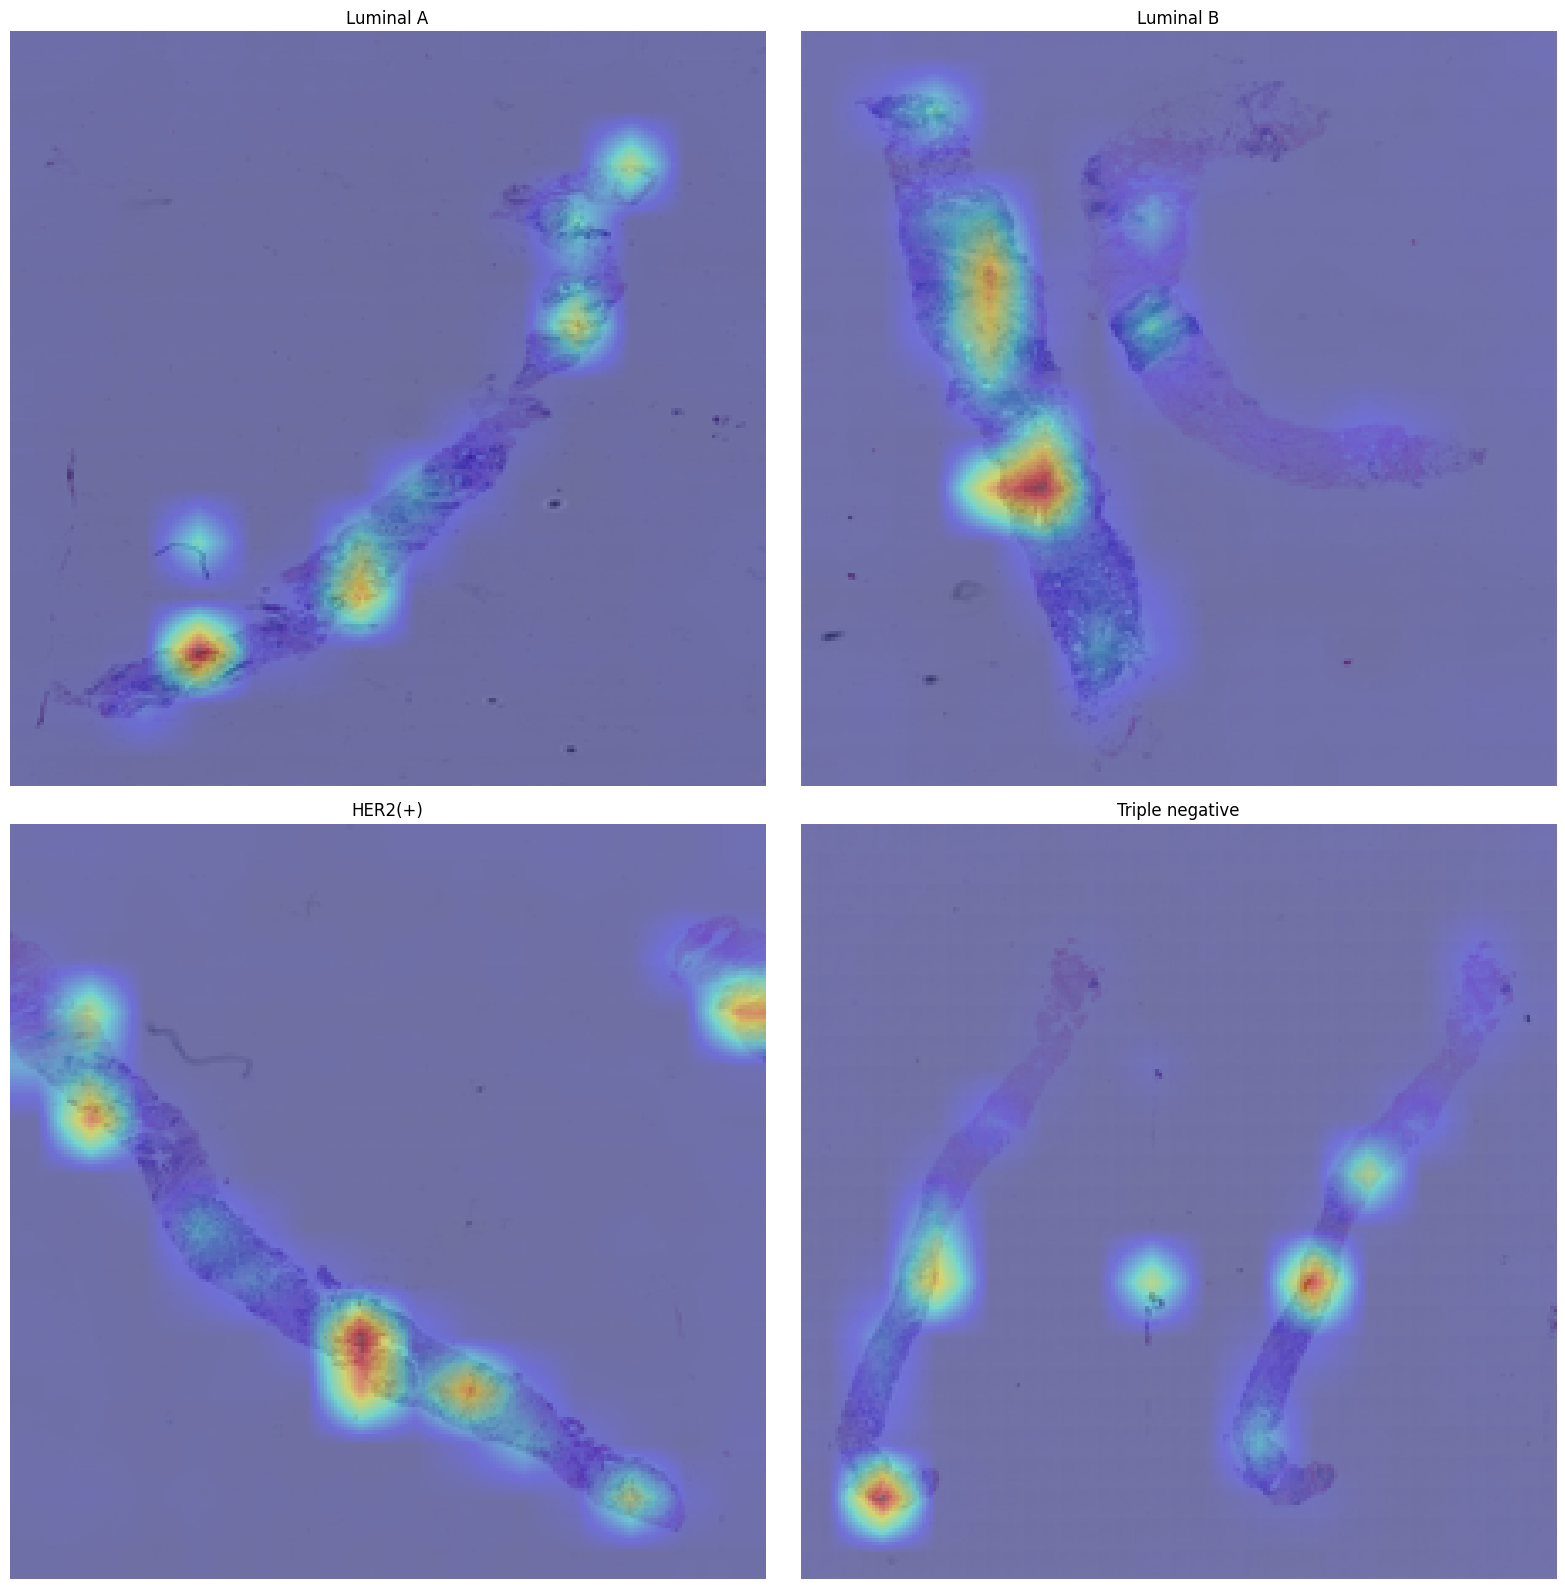

In [ ]:
# --- 12) CAM (ViT attention rollout): 1 image per class ---
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Recent Transformers may use attention implementations that do NOT support output_attentions.
# We force (if available) a compatible implementation to extract attention maps.
if hasattr(backbone, "set_attn_implementation"):
    try:
        backbone.set_attn_implementation("eager")
    except Exception as e:
        print("[WARN] Unable to set attn_implementation='eager':", repr(e))


def _attention_rollout(attentions):
    """Return CLS->patch attention rollout mask for a single image.

    attentions: tuple/list of tensors (1, heads, tokens, tokens) per layer."""
    if attentions is None or len(attentions) == 0:
        raise RuntimeError(
            "The backbone did not return attentions. "
            "Note: in Transformers >= 4.55 it is often necessary to set attn_implementation='eager' (see warning above)."
        )

    tokens = attentions[0].shape[-1]  # 1 (CLS) + num_patches
    device_ = attentions[0].device

    result = torch.eye(tokens, device=device_).unsqueeze(0)  # (1, tokens, tokens)
    for attn in attentions:
        # (1, heads, tokens, tokens) -> (1, tokens, tokens)
        attn_fused = attn.mean(dim=1)
        # residual connection
        attn_fused = attn_fused + torch.eye(tokens, device=device_).unsqueeze(0)
        attn_fused = attn_fused / attn_fused.sum(dim=-1, keepdim=True).clamp_min(1e-12)
        result = torch.bmm(attn_fused, result)

    # CLS attends to patches (exclude CLS token itself)
    mask = result[:, 0, 1:]  # (1, num_patches)
    return mask


def _infer_patch_grid(num_patches: int) -> int:
    g = int(np.sqrt(num_patches))
    if g * g == num_patches:
        return g
    # fallback to config if available
    if hasattr(backbone, "config") and hasattr(backbone.config, "image_size") and hasattr(backbone.config, "patch_size"):
        return int(backbone.config.image_size // backbone.config.patch_size)
    raise RuntimeError(f"Num patches non quadrato ({num_patches}); impossibile inferire la griglia.")


def _cam_for_image(img: Image.Image, input_size: int) -> np.ndarray:
    """Compute attention-rollout CAM for a PIL image; returns (H,W) in [0,1]."""
    backbone.eval()

    img_r = img.convert("RGB").resize((int(input_size), int(input_size)))
    inputs = processor(images=img_r, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    with torch.no_grad():
        out = backbone(pixel_values=pixel_values, output_attentions=True, return_dict=True)
        attns = getattr(out, "attentions", None)
        mask = _attention_rollout(attns)  # (1, num_patches)

    num_patches = int(mask.shape[1])
    grid = _infer_patch_grid(num_patches)
    mask_2d = mask.reshape(1, 1, grid, grid)
    mask_up = F.interpolate(mask_2d, size=(int(input_size), int(input_size)), mode="bilinear", align_corners=False)
    cam = mask_up[0, 0].detach().float().cpu().numpy()
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-12)
    return cam


def _pick_one_image_per_class(df_in):
    picks = {}
    for cname in class_names:
        sub = df_in[df_in[LABEL_COLUMN] == cname]
        picks[cname] = None if len(sub) == 0 else str(sub.iloc[0][ID_COLUMN])
    return picks


# Select 1 image per class from train
picks = _pick_one_image_per_class(df)
print("Selected samples:", picks)

# Plot: 1 column per class, with CAM overlay
n = len(class_names)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.ravel()
if n == 1:
    axes = [axes]

for ax, cname in zip(axes, class_names):
    fname = picks.get(cname)
    ax.set_title(cname)
    ax.axis("off")
    if fname is None:
        ax.text(0.5, 0.5, "(missing)", ha="center", va="center")
        continue

    path = os.path.join(TRAIN_IMG_DIR, fname)
    img = Image.open(path)
    img_r = img.convert("RGB").resize((int(cfg.input_size), int(cfg.input_size)))
    cam = _cam_for_image(img, input_size=int(cfg.input_size))

    ax.imshow(img_r)
    ax.imshow(cam, cmap="jet", alpha=0.40)

plt.tight_layout()
plt.show()